In [1]:
import matplotlib.pyplot as plt


In [11]:
from pytrends.request import TrendReq
import googletrans as gt
import pandas as pd
import datetime
import warnings

class Trendsetter():
    
    def __init__(self, timezone=1, language='en-US'):
        """
        Args:
            timezone: timezone in hours
            language: language of interface, not important
        """
        self.tz = -60*timezone
        self.countries = {'united_states': ['US', 'en'],
                         'united_kingdom': ['GB', 'en'],
                         'australia': ['AU', 'en'],
                         'germany': ['DE', 'de'],
                         'france': ['FR', 'fr'],
                         'italy': ['IT', 'it'],
                         'japan': ['JP', 'ja'],
                         'saudi_arabia': ['SA', 'ar'],
                         'egypt': ['EG', 'ar'],
            #              'china': ['CN', 'zh-cn'],
            #              'iran': ['IR', 'ar'],
                         'brazil': ['BR', 'pt'],
                         'india': ['IN', 'hi'],
                         'israel': ['IL', 'iw'],
            #              'spain': ['ES', 'es'],
                         'mexico': ['MX', 'es'],
                         'russia': ['RU', 'ru'],
                         'south_korea': ['KR', 'ko'],
                         'taiwan': ['TW', 'zh-tw'],
                         'hong_kong': ['HK', 'zh-tw'],
                         'thailand': ['TH','th'],
                         'turkey': ['TR', 'tr'],
                         'vietnam': ['VN', 'vi']
                        }
        self.countrycodes = {v[0]: k for k, v in self.countries.items()}
        self.trends = TrendReq(hl=language, tz=self.tz)
        self.translator = gt.Translator(
            service_urls=["translate.google.com", "translate.google.co.kr",
                          "translate.google.at", "translate.google.de",
                          "translate.google.ru", "translate.google.ch",
                          "translate.google.fr", "translate.google.es"])
        
        
    def browse_categories(self, levels=list()):
        """browse categories by list of index
        Args:
            levels: list, eg. [4,2]
        
        Returns:
            dataframe with child categories
        """
        cat = self.trends.categories()
        for i in levels:
            cat = cat['children'][i]
        
        print(cat['name'], ", id =", cat['id'])
        if 'children' in cat.keys():
            children = pd.DataFrame.from_dict(cat['children'])
            # children.index = children['id']
            return children
        
        
    def get_trending(self, country='united_states'):
        """
        get currently and daily trends for implemented countries
        
        Args:
            country: country name or country code
        
        Returns:
            {'trending': list, 'today': list}
            
        Raises:
            ValueError if country not supported
        """
        
        if country not in self.countries:
            if country in self.countrycodes:
                country = self.countrycodes[country]
            else:
                raise ValueError("Country not supported.")
        
        self.trending = {'trending': list(self.trends.trending_searches(pn=country)[0]),
                         'today': list(self.trends.today_searches(pn=self.countries[country][0]))}
        
        if self.countries[country][1] != 'en':
            try:
                self.trending_en = {k+'_en': 
                                    list(map(lambda t: t.text,
                                             self.translator.translate(v, dest='en', src=self.countries[country][1])))
                                for k, v in self.trending.items()}
                self.trending.update(self.trending_en)
            except JSONDecodeError:
                warnings.warn("google translate API limit reached")
            
        
        return self.trending
    
    
    def get_related(self, kw, timeframe='now 7-d', category=0, location='', gtype=''):
        """
        Args:
            kw: single keywords string
            timeframe: supported google format. or [t_start, t_end]; for daily output: 'YYYY-mm-dd',
                       for hourly output: 'YYYY-mm-ddThh'
            category:
            location: supported google location or country code
            gtype: one of the following: '', images, news, youtube, froogle
        
        Returns:
            DataFrame
        """
        if isinstance(timeframe, list):
            tf_str = ' '.join(timeframe)
        else:
            tf_str = timeframe

        self.trends.build_payload([kw], cat=category, timeframe=tf_str, geo=location, gprop=gtype)
        related_topics = self.trends.related_topics()[kw]
        related_topics = related_topics['top'].append(related_topics['rising'], ignore_index=True, sort=False)

        return related_topics


    def get_interest(self, kwds, timeframe='now 7-d', category=0, location='', gtype=''):
        """
        
        Args:
            kwds: list of up to 5 keywords
            timeframe: supported google format. or [t_start, t_end]; for daily output: 'YYYY-mm-dd',
                       for hourly output: 'YYYY-mm-ddThh'
            category:
            location: supported google location or country code
            gtype: one of the following: '', images, news, youtube, froogle
            
        Returns:
            DataFrame
        """
        if isinstance(kwds, str):
            kwds = [kwds]
        
        if isinstance(timeframe, list):
            tf_str = ' '.join(timeframe)
        else:
            tf_str = timeframe
            timeframe = timeframe.split(' ')

        if 'T' in tf_str: # hourly data
            format_str = '%Y-%m-%dT%H'
        else: # daily data
            format_str = '%Y-%m-%d'

        # needs improvement:
        if any(s in tf_str for s in ['now', 'today', 'all']):
            self.trends.build_payload(kwds, cat=category, timeframe=tf_str, geo=location, gprop=gtype)
            self.interest = self.trends.interest_over_time()
        else:
            t_start = datetime.datetime.strptime(timeframe[0], format_str)
            t_end = datetime.datetime.strptime(timeframe[1], format_str)
            if 'T' in tf_str and t_end-t_start >= datetime.timedelta(days=8):
                self.interest = self.trends.get_historical_interest(kwds,
                                          year_start=t_start.year, year_end=t_end.year,
                                          month_start=t_start.month, month_end=t_end.month,
                                          day_start=t_start.day, day_end=t_end.day,
                                          hour_start=t_start.hour, hour_end=t_end.hour,
                                          cat=category, geo=location, gprop=gtype, sleep=60)
            else:
                self.trends.build_payload(kwds, cat=category, timeframe=tf_str, geo=location, gprop=gtype)
                self.interest = self.trends.interest_over_time()
        return self.interest

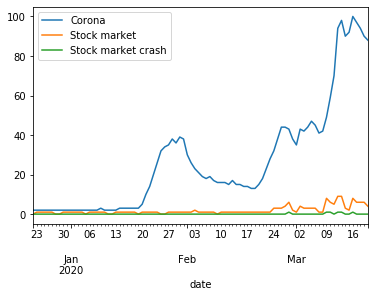

In [23]:
kw_dict = {'/m/0g9pc': 'Corona', '/m/0drqp': 'Stock market', '/m/0gz_4': 'Stock market crash'}

ts = Trendsetter()
# trending = ts.get_trending('DE')
# print(trending)

# ts.get_related('stock market')

interest = ts.get_interest(kw_dict.keys(), 'today 3-m')
interest.columns = [kw_dict[c] if c in kw_dict else c for c in interest.columns]
interest.plot()

todo: how to get from trending to topics?

In [171]:
trends.suggestions(kw)

[{'mid': '/m/0hk4q', 'title': 'Baden-Württemberg', 'type': 'German state'},
 {'mid': '/g/122_rwkh',
  'title': 'Baden-Wurttembergische Bank AG',
  'type': 'Bank'},
 {'mid': '/m/02pcz34', 'title': 'Rust', 'type': 'Town in Germany'},
 {'mid': '/g/11btx11xfg', 'title': 'Baden-Württemberg', 'type': 'Frigate'},
 {'mid': '/g/11c2k9k1d2', 'title': 'Baden Württemberg', 'type': 'Topic'}]

In [30]:
kw = 'Trump'
ts.trends.build_payload([kw])
related_topics = ts.trends.related_topics()[kw]
related_topics['top'].append(related_topics['rising'], ignore_index=True, sort=False)
related_searches = ts.trends.related_queries()[kw]
related_searches['top'].append(related_searches['rising'], ignore_index=True, sort=False)

,query,value
0,donald trump,100
1,donald,100
2,trump news,36
3,trump twitter,20
4,melania trump,13
5,clinton,10
6,clinton trump,10
7,president trump,9
8,ivanka trump,8
9,trump today,8


In [79]:
ts.trends.build_payload([kw], cat=0, timeframe='2020-03-14T00 2020-03-21T23', geo='', gprop='')
interest_time = ts.trends.interest_over_time()

test = ts.trends.get_historical_interest([kw],
                                      year_start=2020,
                                      year_end=2020,
                                      month_start=3,
                                      month_end=3,
                                      day_start=14,
                                      day_end=21,
                                      hour_start=0,
                                      hour_end=23,
                                      cat=0, geo='', gprop='', sleep=60)
test

,/m/0cqt90,isPartial
date,,
2020-03-14 00:00:00,80,False
2020-03-14 01:00:00,80,False
2020-03-14 02:00:00,73,False
2020-03-14 03:00:00,69,False
2020-03-14 04:00:00,59,False
...,...,...
2020-03-21 17:00:00,56,False
2020-03-21 18:00:00,62,False
2020-03-21 19:00:00,58,False


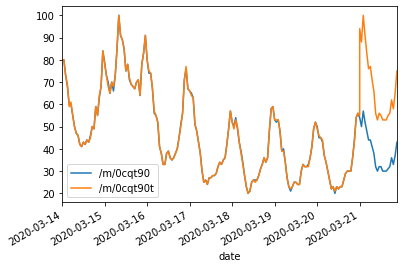

In [80]:
import pandas as pd
interest_time.join(test, rsuffix='t').plot()
plt.show()

In [102]:
# only historic
trends.top_charts(2019, hl='en-US', tz=-60, geo='GLOBAL')

,title,exploreQuery
0,India vs South Africa,
1,Cameron Boyce,
2,Copa America,
3,Bangladesh vs India,
4,iPhone 11,
5,Game of Thrones,
6,Avengers: Endgame,
7,Joker,
8,Notre Dame,
9,ICC Cricket World Cup,
